In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

AR(1) model

$$X_{t} - b = a (X_{t - 1} - b) + \varepsilon_t, \qquad X_1 \sim \mathcal{N}\left(0, \frac{1}{1 - a^2}\right).$$

$$H_0: a_\text{true} = a, b \in \mathbb{R}, \qquad H_1: a_\text{true} \neq a, b \in \mathbb{R}.$$
### Remove no elements
$$\hat{a} = \frac{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}\right)\left(X_{t + 1} - \hat{b}\right)}{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}\right)^2}$$

$$\hat{b} = \frac{\left(\sum X - X_1\right) - a\left(\sum X - X_T\right)}{(T - 1)(1 - a)} = \frac{\sum X}{T-1} - \frac{(X_1 - aX_T)}{(T - 1)(1 - a)}.$$

### Rui's Implementation, slight modification to python, different $\hat{a}$ estimation.

In [2]:
def rui(a0, b, T, iters = 100):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        # generate AR(1)
        X = np.zeros(T)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))
    
        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]
    
        # LOOCV parameter estimates
        
        # approximation estimate for b
        hat_b = (sum(X) - X) / T
    
        hat_a = np.zeros(T)
    
        CV_0 = np.zeros(T)
        CV_1 = np.zeros(T)
    
        for t in range(2, T - 1):
            # approximation estimate for a
            nominator = (X[1:] - hat_b[t]) @ (X[:-1] - hat_b[t]).T - (X[t] - hat_b[t]) * (X[t - 1] + X[t + 1] - 2 * hat_b[t])
            denominator = (sum((X[1:] - hat_b[t]) ** 2) - (X[t] - hat_b[t]) ** 2 - (X[t + 1] - hat_b[t]) ** 2)
            
            hat_a[t] = nominator / denominator
        
            # cross validation scores
            CV_0[t] = (X[t]- hat_b[t] - a0       * (X[t - 1] - hat_b[t])) ** 2
            CV_1[t] = (X[t]- hat_b[t] - hat_a[t] * (X[t - 1] - hat_b[t])) ** 2
        
        count += (sum(CV_0[1:-1]) < sum(CV_1[1:-1]))
        
    return count

a0, b, T, iters = 0.80, 1.0, 100, 50
count = rui(a0, b, T, iters)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 105.71it/s]

P(CV(a = a0 = 0.8) < CV(a = hat(a)) = 0.58.


In [3]:
def rui_2(a0, b, T, iters = 100):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        # generate AR(1)
        X = np.zeros(T)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))
    
        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]
    
        # LOOCV parameter estimates
        
        # approximation estimate for b
        hat_b = (sum(X) - X) / (T - 1)
    
        hat_a = np.zeros(T)
    
        CV_0 = np.zeros(T)
        CV_1 = np.zeros(T)
    
        for t in range(1, T - 1):
            # approximation estimate for a
            nominator = (X[1:] - hat_b[t]) @ (X[:-1] - hat_b[t]).T - (X[t] - hat_b[t]) * (X[t - 1] + X[t + 1] - 2 * hat_b[t])
            denominator = (sum((X[:-1] - hat_b[t]) ** 2) - (X[t] - hat_b[t]) ** 2 - (X[t + 1] - hat_b[t]) ** 2)
            
            hat_a[t] = nominator / denominator
        
            # cross validation scores
            CV_0[t] = (X[t]- hat_b[t] - a0       * (X[t - 1] - hat_b[t])) ** 2
            CV_1[t] = (X[t]- hat_b[t] - hat_a[t] * (X[t - 1] - hat_b[t])) ** 2
        
        count += (sum(CV_0[1:-1]) < sum(CV_1[1:-1]))
        
    return count

a0, b, T, iters = 0.00, 1.0, 100, 50
count = rui_2(a0, b, T, iters)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 124.99it/s]

P(CV(a = a0 = 0.0) < CV(a = hat(a)) = 0.82.


### Martin's $\hat{a}$ implementation.
We can regard the data as $T - 1$ pairs $(x, y)$ of the form $\{(X_t, X_{t+1})\}_{t = 1}^{T - 1}$. Then, LOOCV would remove the $k$th sample, so the $k$th pair $(X_k, X_{k+1})$. The corresponding estimate would then be. Using this $(X, Y)$ pair combination, we can see estimate 

$$\hat{b} = \frac{\left(\sum X - X_1\right) - a\left(\sum X - X_T\right)}{(T - 1)(1 - a)} = \frac{\sum X}{T-1} - \frac{(X_1 - aX_T)}{(T - 1)(1 - a)} \approx \frac{\sum X}{T}.$$ Leaving out, the $k$th pair $(X_k, X_{k+1})$, we would get 

$$\hat{b}^{-k} = \frac{\left(\sum X - X_1 - X_{k + 1}\right) - a\left(\sum X - X_T - X_{k}\right)}{(T - 2)(1 - a)} \approx \frac{\sum X - X_{k}}{T - 1}$$

$$\hat{a}^{-k} = \frac{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}^{-k}\right)\left(X_{t + 1} - \hat{b}^{-k}\right) - \left(X_k - \hat{b}^{-k}\right)\left(X_{k+1} - \hat{b}^{-k}\right)}{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}^{-k}\right)^2 - \left(X_k - \hat{b}^{-k}\right)^2}$$

In [4]:
a0, b, T = 0.8, 1.0, 10
count, iters = 0, 5000

for _ in tqdm(range(iters)):

    X = np.zeros(T)
    
    # generate AR(1)
    X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))
    
    noises = np.random.normal(0, 1, T - 1)
    for t in range(1, T):
        X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]
    
    # LOOCV parameter estimates approximation
    hat_b = (sum(X) - X) / (T - 1)
    
    hat_a = np.zeros(T)
    
    CV_0 = np.zeros(T)
    CV_1 = np.zeros(T)
    
    for t in range(T - 1):
        nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
        denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])
        
        hat_a[t] = nomin / denom
                   
        CV_0[t] = (X[t + 1]- hat_b[t] - a0       * (X[t] - hat_b[t])) ** 2
        CV_1[t] = (X[t + 1]- hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2
        
    count += (sum(CV_0[:-1]) < sum(CV_1[:-1]))

print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2858.75it/s]

P(CV(a = a0 = 0.8) < CV(a = hat(a)) = 0.683.


### Remove all information of $(x, y)$ pair $(X_k, X_{k+1})$.

In [5]:
def martin_remove_x_k_pair(a0, b, T, iters = 100):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a0 * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a0))

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(T - 1):            
            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            hat_a[t] = nomin / denom

            CV_0[t] = (X[t + 1] - hat_b[t] - a0       * (X[t] - hat_b[t])) ** 2
            CV_1[t] = (X[t + 1] - hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2

        count += (sum(CV_0) < sum(CV_1))
    
    return count

a0, b, T, iters = 0.999, 0, 100, 1000
count = martin_remove_x_k_pair(a0, b, T, iters)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.01it/s]

P(CV(a = a0 = 0.999) < CV(a = hat(a)) = 0.184.


### Remove all information of $X_k$

We can regard the data as $T - 1$ pairs $(x, y)$ of the form $\{(X_t, X_{t+1})\}_{t = 1}^{T - 1}$. Then, LOOCV would remove the two samples pairs $(X_{k - 1}, X_{k})$, $(X_k, X_{k+1})$. Leaving out, the 2 pairs $(X_{k - 1}, X_{k})$, $(X_k, X_{k+1})$, we would get 

$$\hat{b}^{-k} = \frac{\left(\sum X - X_1 - X_{k + 1} - X_k\right) - a\left(\sum X - X_T - X_{k} - X_{k - 1}\right)}{(T - 3)(1 - a)} \approx \frac{\sum X - X_k}{T - 1}$$

$$\hat{a}^{-k} = \frac{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}^{-k}\right)\left(X_{t + 1} - \hat{b}^{-k}\right) - \left(X_{k - 1} - \hat{b}^{-k}\right)\left(X_{k} - \hat{b}^{-k}\right) - \left(X_k - \hat{b}^{-k}\right)\left(X_{k+1} - \hat{b}^{-k}\right)}{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}^{-k}\right)^2 - \left(X_k - \hat{b}^{-k}\right)^2  - \left(X_{k - 1} - \hat{b}^{-k}\right)^2}$$

In [6]:
def martin_remove_x_k_both(a0, b, T, iters):
    
    count = 0
    
    np.random.seed(seed = 123)
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        hat_b[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a0 * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a0))
        # hat_b[1:-1] = (sum(X[1:] - a0 * X[:-1]) - (1 - a0) * X[1:-1] - X[2:] + a0 * X[:-2]) / ((T - 3) * (1 - a0))
        
        # approx
        # hat_b = (sum_X - X) / (T - 1)

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(1, T - 1):
            hat_b_2 = ((sum_X - X[0] - X[t] - X[t + 1]) - a0 * (sum_X - X[-1] - X[t] - X[t - 1])) / ((T - 3) * (1 - a0))

            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t]     - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t]) 
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t - 1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            hat_a[t] = nomin / denom
            
            CV_0[t] = (X[t + 1] - hat_b[t] - a0       * (X[t] - hat_b[t])) ** 2
            CV_1[t] = (X[t + 1] - hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2
        
        #print(round(sum(CV_0)), round(sum(CV_1)))
        count += (sum(CV_0) < sum(CV_1))
        
    return count

a0, b, T, iters = 0.65, 0, 51, 100
count = martin_remove_x_k_both(a0, b, T, iters)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.89it/s]

P(CV(a = a0 = 0.65) < CV(a = hat(a)) = 0.91.


### 3D Grid Search

In [1021]:
a_range = [0.0, 0.25, 0.6, 0.8, 0.9, 0.99, 0.999]
b_range = [0.0] # np.linspace(-15, 15, 3)
T_range = [51, 101]
iters = 10
iters2 = 100

num_methods = 4

results = np.zeros((num_methods, len(a_range), len(b_range), len(T_range)))

for i, a in enumerate(a_range):
    print("a", a)
    for j, b in enumerate(b_range):
        for k, T in enumerate(T_range):
#             results[0][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = True, iter_estimate = False, iters2 = iters2) / iters
#             results[1][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = False, iter_estimate = False, iters2 = iters2) / iters
            results[2][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2) / iters
            print(results[2][i][j][k])
#             results[3][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2) / iters

  5%|███▉                                                                           | 50/1000 [00:00<00:03, 246.60it/s]

a 0.0


  1%|▋                                                                                | 8/1000 [00:00<00:13, 72.73it/s]

0.824


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 220.00it/s]

0.828
a 0.25


  1%|▌                                                                                | 7/1000 [00:00<00:14, 67.97it/s]

0.833


  1%|▋                                                                                | 8/1000 [00:00<00:14, 70.80it/s]

0.835
a 0.6


  1%|▋                                                                                | 9/1000 [00:00<00:11, 83.31it/s]

0.822


  1%|█                                                                              | 14/1000 [00:00<00:07, 134.61it/s]

0.823
a 0.8


  1%|▋                                                                                | 9/1000 [00:00<00:12, 80.33it/s]

0.792


  2%|█▍                                                                             | 18/1000 [00:00<00:05, 179.95it/s]

0.814
a 0.9


  1%|▊                                                                               | 10/1000 [00:00<00:10, 90.07it/s]

0.729


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 180.96it/s]

0.792
a 0.99


 46%|███████████████████████████████████▋                                          | 458/1000 [00:02<00:03, 177.62it/s]

1 -1.0126299798685068e-10 PROBLEM


  2%|█▏                                                                              | 15/1000 [00:00<00:13, 71.12it/s]

0.5


  2%|█▎                                                                             | 16/1000 [00:00<00:06, 158.41it/s]

0.569
a 0.999


  1%|▌                                                                                | 7/1000 [00:00<00:15, 66.02it/s]

0.477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.45it/s]

0.442


### Plot for a given $b$

In [7]:
b_index = -1
n_method = 2
a_index = 0
t_index = -1
# T_range = [51, 101, 251, 501]

methods = ["removing (Xk, Xk+1)", "removing (Xk, Xk+1) and (Xk-1, Xk)", "removing (Xk, Xk+1) and (Xk-1, Xk), iterative MLE estimation", "removing (Xk, Xk+1), iterative MLE estimation"]
plt.figure(figsize = (10, 4))
plt.title(f"P(CV success for b = {b_range[b_index]}), {methods[n_method]}.")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(results[n_method, :, b_index, :].T):
    plt.plot(np.append(0, a_range), np.append(plot[0], plot), label = f"T = {T_range[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $T$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), {methods[n_method]}.")
for i, plot in enumerate(results[n_method, :, b_index, :]):
    plt.plot(T_range, plot, label = f"a = {a_range[i]}")
    plt.fill_between(T_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.17, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $T$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), a = {a_range[a_index]}.")
for i, plot in enumerate(results[:, a_index, b_index, :]):
    plt.plot(T_range, plot, label = f"{methods[i]}")
    plt.fill_between(T_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=2, fancybox=True, shadow=True)

plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $a$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), T = {T_range[t_index]}.")
for i, plot in enumerate(results[:, :, b_index, t_index]):
    plt.plot(a_range, plot, label = f"{methods[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=2, fancybox=True, shadow=True)

plt.show()

NameError: name 'b_range' is not defined

<Figure size 720x288 with 0 Axes>

In [ ]:
print(results)

In [ ]:
# print(np.shape(results))
# print(np.shape(bckp))

# # results_2 = np.append(bckp, results, axis = -1)
# print(results_2)

In [ ]:
# bckp = results.copy()
# print(results)

### Plot $a$ and $b$ for given $T$

In [ ]:
plt.figure(figsize = (10, 4))
t_index = 0
n_method = 0

plt.title(f"P(CV success for T = {T_range[t_index]}).")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(results[n_method, :, :, t_index].T):
    plt.plot(a_range, plot, label = f"b = {b_range[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.title(f"P(CV success for T = {T_range[t_index]}).")
plt.xlabel(r"Value of $b$.")

for i, plot in enumerate(results[n_method, :, :, t_index]):
    plt.plot(b_range, plot, label = f"a = {a_range[i]}")
    plt.fill_between(b_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

### Plot for given $a$

In [ ]:
a_index = 3
n_method = 0

plt.title(f"P(CV success for a = {a_range[a_index]}).")
plt.xlabel(r"Value of $b$.")

for i, plot in enumerate(results[n_method, a_index, :, :].T):
    plt.plot(b_range, plot, label = f"T = {T_range[i]}")
    plt.fill_between(b_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

plt.title(f"P(CV success for a = {a_range[a_index]}).")
plt.xlabel(r"Value of $T$.")

for i, plot in enumerate(results[n_method, a_index, :, :]):
    plt.plot(T_range, plot, label = f"b = {b_range[i]}")
    plt.fill_between(T_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

In [ ]:
b_index = -1
n_method = 1

plt.figure(figsize = (10, 4))
plt.title(f"P(CV success for b = {b_range[b_index]}) removing $k$th pair.")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(results[n_method, :, b_index, :].T):
    plt.plot(a_range, plot, label = f"T = {T_range[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $T$.")
plt.title(f"P(CV success for b = {b_range[b_index]}) removing $k$th pair.")
for i, plot in enumerate(results[n_method, :, b_index, :]):
    plt.plot(T_range, plot, label = f"a = {a_range[i]}")
    plt.fill_between(T_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)

plt.show()

In [ ]:
# bckp_2 = results.copy()
# bckp = results.copy()

In [ ]:
bckp_3 = results.copy()

In [8]:
def martin_remove_x_k_both_2(a, b, T, iters, iters2):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a0 ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a0 * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        hat_b[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a0 * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a0))

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(T - 2, T - 1):
            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t]     - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t]) 
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t - 1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            hat_a[t] = nomin / denom
            
            a_est, b_est = loocv_two_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)
            
            CV_0[t] = (X[t + 1] - b_est - a0    * (X[t] - b_est)) ** 2
            CV_1[t] = (X[t + 1] - b_est - a_est * (X[t] - b_est)) ** 2

        #print(round(sum(CV_0)), round(sum(CV_1)))
        count += (sum(CV_0) < sum(CV_1))
        
    return count

a0, b, T, iters, iters2 = 0.5, 0, 51, 1, 10
count = martin_remove_x_k_pair_2(a0, b, T, iters, iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

NameError: name 'martin_remove_x_k_pair_2' is not defined

In [9]:
def martin_remove_x_k_pair_2(a, b, T, iters = 100, iters2 = 5):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(1, T - 1):             
            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            hat_a[t] = nomin / denom
            
            a_est, b_est = loocv_one_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)
            CV_0[t] = (X[t + 1] - b_est - a     * (X[t] - b_est)) ** 2
            CV_1[t] = (X[t + 1] - b_est - a_est * (X[t] - b_est)) ** 2

        count += (sum(CV_0) < sum(CV_1))
    
    return count

a0, b, T, iters, iters2 = 0.5, 0, 101, 10, 1000
count = martin_remove_x_k_pair_2(a0, b, T, iters, iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


NameError: name 'loocv_one_pair' is not defined

In [10]:
def martin_remove_x_k_pair_3(a, b, T, iters = 100, iters2 = 5):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
        
        hat_b_2 = np.zeros(T)
        hat_b_2[:-1] = (sum_X - X[:-1]) / (T - 1)

        hat_a = np.zeros(T)
        hat_a_2 = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(1, T - 1):             
            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            hat_a[t] = nomin / denom
            
            nomin = np.dot(X[:-1] - hat_b_2[t], X[1:]  - hat_b_2[t]) - (X[t] - hat_b_2[t]) * (X[t + 1] - hat_b_2[t])
            denom = np.dot(X[:-1] - hat_b_2[t], X[:-1] - hat_b_2[t]) - (X[t] - hat_b_2[t]) * (X[t]     - hat_b_2[t])

            hat_a_2[t] = nomin / denom
            
            a_est, b_est = loocv_one_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)
            
            a_est_2, b_est_2 = loocv_one_pair(hat_a_2[t], hat_b_2[t], X, t, sum_X, T, iters = iters2)

            CV_0[t] = (X[t + 1] - b_est - a     * (X[t] - b_est)) ** 2
            CV_1[t] = (X[t + 1] - b_est - a_est * (X[t] - b_est)) ** 2

        count += (sum(CV_0) < sum(CV_1))
    
    return count

a0, b, T, iters, iters2 = 0.99, 0, 101, 10, 1000
count = martin_remove_x_k_pair_2(a0, b, T, iters, iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


NameError: name 'loocv_one_pair' is not defined

In [11]:
# remove X_k_pair.
# Use estimate for b without a
# Iteratively estimate a and b to find the true MLEs

def martin_remove_x_k_pair_4(a, b, T, iters = 100, iters2 = 5):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        
        # exact, but we do not have a
        # hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
        # approximate, use for iterative procedure
        hat_b[:-1] = (sum_X - X[:-1]) / (T - 1)

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        for t in range(1, T - 1):             
            nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
            denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])

            # initial estimate for a
            hat_a[t] = nomin / denom
            
            # iteratively estimate a and b until maximum
            a_est, b_est = loocv_one_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)

            # compare a_est and b_est
            CV_0[t] = (X[t + 1] - b_est - a     * (X[t] - b_est)) ** 2
            CV_1[t] = (X[t + 1] - b_est - a_est * (X[t] - b_est)) ** 2

        count += (sum(CV_0) < sum(CV_1))
    
    return count

a0, b, T, iters, iters2 = 0.0, 100, 501, 50, 1000
count = martin_remove_x_k_pair_4(a0, b, T, iters, iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


NameError: name 'loocv_one_pair' is not defined

In [8]:
def loocv_one_pair(a, b, X, t, sum_X, T, iters = 3, tol = 1e-3):
    
    old_ll = ll_p(X, a, b, t)
    for i in range(iters):
        a = (np.dot(X[:-1] - b, X[1:]  - b) - (X[t] - b) * (X[t + 1] - b)) / (np.dot(X[:-1] - b, X[:-1] - b) - (X[t] - b) * (X[t] - b))
        b = ((sum_X - X[0] - X[t + 1]) - a * (sum_X - X[-1] - X[t])) / ((T - 2) * (1 - a))
        
        new_ll = ll_p(X, a, b, t)
        
        # maximize, so new should be larger than old, so new - old should be > 0
        if new_ll - old_ll < -1e10:
            print(i, new_ll - old_ll, "PROBLEM")
        if new_ll - old_ll < tol:
            old_ll = new_ll
            break
            
        old_ll = new_ll
    return a, b

def ll_p(X, a, b, t):
    ll_temp = (X[1:] - b - a * (X[:-1] - b))
    ll = -0.5 * sum(ll_temp ** 2) + 0.5 * (X[t + 1] - b - a * (X[t] - b)) ** 2 
    return ll

def ll_b(X, a, b, t):
    ll_temp = (X[1:] - b - a * (X[:-1] - b))
    ll = -0.5 * sum(ll_temp ** 2) + 0.5 * (X[t + 1] - b - a * (X[t] - b)) ** 2 + 0.5 * (X[t] - b - a * (X[t - 1] - b)) ** 2
    return ll

In [9]:
def opt_a_b(a, b, X, sum_X, T, iters = 3, tol = 1e-3):
    
    old_a, old_b = a, b
    
    print(ll_n(X, a, b))
    for i in range(iters):
        
        old_a, old_b = a, b
        
        # update a using estimate of b
        a = (np.dot(X[:-1] - b, X[1:]  - b)) / (np.dot(X[:-1] - b, X[:-1] - b))
        # update b using estimate of a
        b = ((sum_X - X[0]) - a * (sum_X - X[-1])) / ((T - 1) * (1 - a))
        
        print(ll_n(X, a, b))
             
    return a, b

def ll_n(X, a, b):
    ll = -0.5 * sum((X[1:] - b - a * (X[:-1] - b)) ** 2)
    return ll

In [10]:
def loocv_two_pair(a, b, X, t, sum_X, T, iters = 3, tol = 1e-1):
    
    old_ll = ll_b(X, a, b, t)
    for i in range(iters):
        # update a using estimate of b
        a = (np.dot(X[:-1] - b, X[1:]  - b) - (X[t] - b) * (X[t + 1] - b) - (X[t - 1] - b) * (X[t] - b)) / (np.dot(X[:-1] - b, X[:-1] - b) - (X[t] - b) * (X[t]  - b) - (X[t - 1] - b) * (X[t - 1]  - b))
        # update b using estimate of a
        b = ((sum_X - X[0] - X[t] - X[t + 1]) - a * (sum_X - X[-1] - X[t] - X[t - 1])) / ((T - 3) * (1 - a))

        new_ll = ll_b(X, a, b, t)
        
        # maximize, so new should be larger than old, so new - old should be > 0
        if new_ll - old_ll < -1e-10:
            print(i, new_ll - old_ll, "PROBLEM")
        if new_ll - old_ll < tol:
            old_ll = new_ll
            break
            
        old_ll = new_ll
    return a, b

In [11]:
# remove X_k_pair.
# Use estimate for b without a
# Iteratively estimate a and b to find the true MLEs

def ar_loocv(a, b, T, iters = 100, approx_b = True, iter_estimate = False, one_pair = True, iters2 = 5):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        X = np.zeros(T)

        # generate AR(1)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

        noises = np.random.normal(0, 1, T - 1)
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        sum_X = sum(X)

        # LOOCV parameter estimates
        hat_b = np.zeros(T)
        
        if not approx_b:
            # exact, but we do not have a
            hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
        else:
            # approximate, use for iterative procedure
            hat_b[:-1] = (sum_X - X[:-1]) / (T - 1)

        hat_a = np.zeros(T)

        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)

        if one_pair:
            hat_a[1:-1] = get_a_hat_pair(X, hat_b)
        else:
            hat_a[1:-1] = get_a_hat_both(X, hat_b)
        
        print(hat_a[1:-1])
        for t in range(1, T - 1):      
            if one_pair:
                nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t])
                denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t])
                
                # initial estimate for a
                hat_a[t] = nomin / denom
                
                if iter_estimate:
                    hat_a[t], hat_b[t] = loocv_two_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)
                    
            else:
                nomin = np.dot(X[:-1] - hat_b[t], X[1:]  - hat_b[t]) - (X[t] - hat_b[t]) * (X[t + 1] - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t] - hat_b[t])
                denom = np.dot(X[:-1] - hat_b[t], X[:-1] - hat_b[t]) - (X[t] - hat_b[t]) * (X[t]     - hat_b[t]) - (X[t - 1] - hat_b[t]) * (X[t - 1]     - hat_b[t])
                
                # initial estimate for a
                hat_a[t] = nomin / denom
                
                # iteratively estimate a and b until maximum
                if iter_estimate:
                    hat_a[t], hat_b[t] = loocv_two_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)

            # compare a_est and b_est
            CV_0[t] = (X[t + 1] - hat_b[t] - a        * (X[t] - hat_b[t])) ** 2
            CV_1[t] = (X[t + 1] - hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2

        print(hat_a[1:-1])
        count += (sum(CV_0) < sum(CV_1))
    
    return count

a0, b, T, iters, iters2 = 0.999, 100, 51, 1, 0
count = ar_loocv(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = False, iters2 = iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


NameError: name 'get_a_hat_both' is not defined

In [12]:
X = np.linspace(0, 1, 10001)
b_range = np.linspace(1, 2, 10001)

def get_a_hat_pair(X, b):
    A = (X[:-1] - np.expand_dims(b[1:-1], axis = 1))
    B = (X[1:] - np.expand_dims(b[1:-1], axis = 1))
    nomin = (A * B).sum(-1) - (X[1:-1] - b[1:-1]) * (X[2:] - b[1:-1])
    denom = (A * A).sum(-1) - (X[1:-1] - b[1:-1]) ** 2
    
    return nomin / denom

def get_a_hat_both(X, b):
    A = (X[:-1] - np.expand_dims(b[1:-1], axis = 1))
    B = (X[1:] - np.expand_dims(b[1:-1], axis = 1))
    nomin = (A * B).sum(-1) - (X[1:-1] - b[1:-1]) * (X[2:] - b[1:-1]) - (X[:-2] - b[1:-1]) * (X[1:-1] - b[1:-1])
    denom = (A * A).sum(-1) - (X[1:-1] - b[1:-1]) ** 2 - (X[:-2] - b[1:-1]) ** 2
    
    return nomin / denom

def get_a_hat_both_v2(X, b):
    
    hat_a = np.zeros(T - 2)
    
    for t in range(1, T - 1):        
        nomin = np.dot(X[:-1] - b[t], X[1:]  - b[t]) - (X[t] - b[t]) * (X[t + 1] - b[t]) - (X[t - 1] - b[t]) * (X[t] - b[t])
        denom = np.dot(X[:-1] - b[t], X[:-1] - b[t]) - (X[t] - b[t]) * (X[t]     - b[t]) - (X[t - 1] - b[t]) * (X[t - 1] - b[t])

        hat_a[t - 1] = nomin / denom
        
    return hat_a

a, b, T = 0.5, 10, 500

## generate AR(1) model
X = np.zeros(T)
X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

# generate noise
noises = np.random.normal(0, 1, T - 1)

# iteratively get value of X
for t in range(1, T):
    X[t] = b + a * (X[t - 1] - b) + noises[t - 1]
            
hat_b = (sum(X) - X[:-1]) / (T - 1)

import time
start = time.time()
print(np.shape(get_a_hat_both(X, np.append(hat_b, 0))))
end = time.time()
print(end - start)
print(np.shape(get_a_hat_both_v2(X, np.append(hat_b, 0))))
print(time.time() - end)

(498,)
0.004999399185180664
(498,)
0.010030031204223633


In [13]:
# remove X_k_pair.
# Use estimate for b without a
# Iteratively estimate a and b to find the true MLEs

def ar_loocv_2(a, b, T, iters = 100, approx_b = True, iter_estimate = False, one_pair = True, iters2 = 5):
    
    count = 0
    
    for _ in tqdm(range(iters)):

        ## generate AR(1) model
        X = np.zeros(T)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))
        
        # generate noise
        noises = np.random.normal(0, 1, T - 1)
        
        # iteratively get value of X
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        # get sum
        sum_X = sum(X)

        # LOOCV parameter estimates, CV scores
        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)
        hat_a = np.zeros(T)
        hat_b = np.zeros(T)
        
        b_est = ((sum_X - X[0]) - a * (sum_X - X[-1])) / ((T - 1) * (1 - a))
        
        hat_b_one = np.zeros(T)
        
        if one_pair:
            hat_b_one[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
        else: 
            hat_b_one[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a))
            
        # estimate b, either exact or approximate
        if not approx_b:
            if one_pair:
                hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
            else:
                hat_b[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a))
        else:
            hat_b[:-1] = (sum_X - X[:-1]) / (T - 1)
        
        # estimate a, either remove pair (X_k, X_k+1) or also (X_k-1, X_k)
        if one_pair:
            hat_a[1:-1] = get_a_hat_pair(X, hat_b)
        else:
            hat_a[1:-1] = get_a_hat_both_v2(X, hat_b)
        
        # compute LOOCV score for each sample excluding boundary
        for t in range(1, T - 1):      
            # iteratively estimate to get optimal MLE estimates
            if iter_estimate and one_pair:
                hat_a[t], hat_b[t] = loocv_one_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)                
            elif iter_estimate and not one_pair:
                hat_a[t], hat_b[t] = loocv_two_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)

            # compare a_est and b_est
            CV_0[t] = (X[t + 1] - hat_b_one[t]    - a        * (X[t] - hat_b_one[t]))    ** 2
            CV_1[t] = (X[t + 1] - hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2
            
#             # compare a_est and b_est
#             CV_0[t] = (X[t + 1] - a        * X[t])    ** 2
#             CV_1[t] = (X[t + 1] - hat_a[t] * X[t]) ** 2

#         # get count   
#         print("b:", round(np.mean(b_est), 4), "\t", round(np.mean(hat_b[1:-1]), 4))
#         print("a:", np.mean(a), "\t", np.mean(hat_a[1:-1]))
#         print()
#         print("average empirical risk:\t", round(1 / (T - 1) * np.mean(np.array([np.linalg.norm((X[2:] - b) - a * (X[1:-1] - b), 2) ** 2 for b in hat_b_one[1:-1]])), 4), "\t", round(1 / (T - 1) * np.mean(np.array([np.linalg.norm((X[2:] - b) - a * (X[1:-1] - b), 2) ** 2 for a, b in zip(hat_a[1:-1], hat_b[1:-1])])), 4))
#         print("true risk:\t\t", np.round(np.array(expected_cost_ar(a, a, b, b_est)), 4), "\t", round(np.mean(np.array([expected_cost_ar(a, a_hat, b, b_hat) for a_hat, b_hat in zip(hat_a[1:-1], hat_b[1:-1])])), 4))
#         print("cross-validation score:\t", round(1 / (T - 1) * sum(CV_0), 4), "\t", round(1 / (T - 1) * sum(CV_1), 4))
#         print()
#         print(count)
        
#         print(expected_cost_ar(a, a, b, b_est) / np.mean(np.array([expected_cost_ar(a, a_hat, b, b_hat) for a_hat, b_hat in zip(hat_a[1:-1], hat_b[1:-1])])))
        count += (sum(CV_0) < sum(CV_1))
        
    
    return count

a0, b, T, iters, iters2 = 0.0, 0, 51, 100, 10000
count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2)
print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

# count = martin_remove_x_k_both(a0, b, T, iters)
# print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 185.87it/s]

P(CV(a = a0 = 0.0) < CV(a = hat(a)) = 0.76.


In [29]:
a_range = [0.5]
b_range = [-50, -25, 0, 25, 50] # np.linspace(-15, 15, 3)
T_range = [100]
iters = 10000
iters2 = 1000

num_methods = 4

results = np.zeros((num_methods, len(a_range), len(b_range), len(T_range)))

for i, a in enumerate(a_range):
    print("a", a)
    for j, b in enumerate(b_range):
        for k, T in enumerate(T_range):
            results[0][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2) / iters
#             results[1][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = False, iter_estimate = False, iters2 = iters2) / iters
            # results[2][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2) / iters
            print(results[2][i][j][k])
#             results[3][i][j][k] = ar_loocv_2(a, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2) / iters

  0%|                                                                                | 7/10000 [00:00<02:34, 64.80it/s]

a 0.5


  0%|                                                                                | 8/10000 [00:00<02:12, 75.47it/s]

0.0


  0%|                                                                                | 7/10000 [00:00<02:28, 67.31it/s]

0.0


  0%|                                                                                | 4/10000 [00:00<04:17, 38.84it/s]

0.0


  0%|                                                                                | 4/10000 [00:00<05:02, 33.05it/s]

0.0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:09<00:00, 52.80it/s]

0.0


In [35]:
results[n_method, 0, :, 0]

results[n_method, 0, 2, 0] = 0.8263

In [42]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


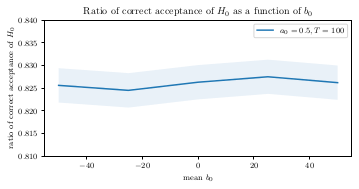

In [46]:
plt.figure(figsize = (5.5, 2.5))
plt.xlabel(r"mean $b_0$")
plt.ylabel("ratio of correct acceptance of $H_0$")
plt.title(f"Ratio of correct acceptance of $H_0$ as a function of $b_0$")
plot = results[n_method, 0, :, 0]
plt.ylim(0.81, 0.84)
plt.plot(b_range, plot, label = "$a_0 = 0.5, T = 100$")
plt.fill_between(b_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
# plt.legend(loc='upper right', bbox_to_anchor=(1.17, 1),
#           ncol=1, fancybox=True, shadow=True)

plt.legend()
plt.savefig("rchob.pgf", bbox_inches = 'tight')
plt.show()

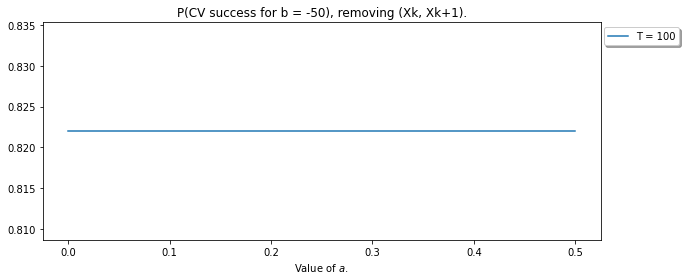

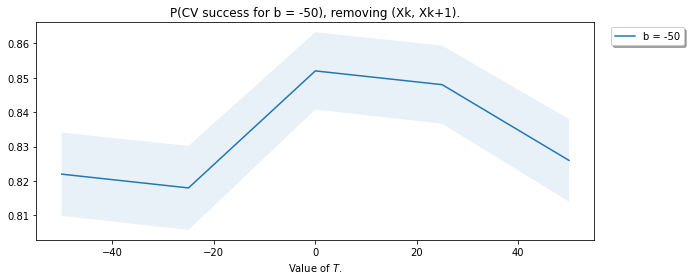

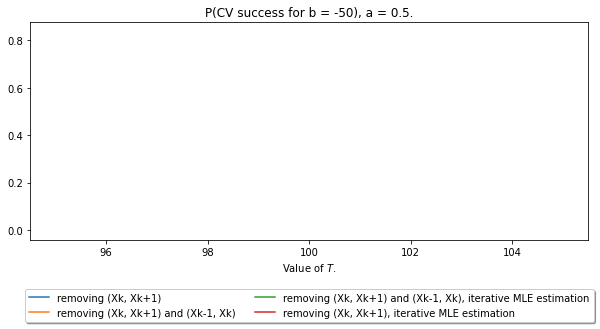

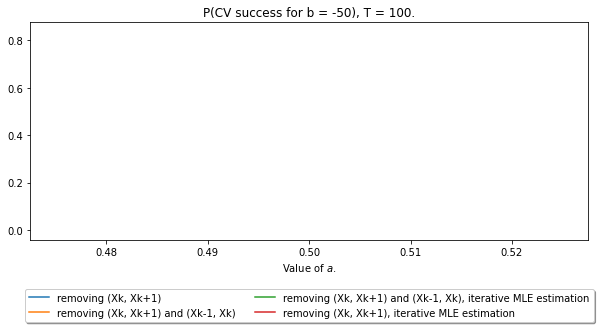

In [24]:
b_index = 0
n_method = 0
a_index = 0
t_index = 0
# T_range = [51, 101, 251, 501]

methods = ["removing (Xk, Xk+1)", "removing (Xk, Xk+1) and (Xk-1, Xk)", "removing (Xk, Xk+1) and (Xk-1, Xk), iterative MLE estimation", "removing (Xk, Xk+1), iterative MLE estimation"]
plt.figure(figsize = (10, 4))
plt.title(f"P(CV success for b = {b_range[b_index]}), {methods[n_method]}.")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(results[n_method, :, b_index, :].T):
    plt.plot(np.append(0, a_range), np.append(plot[0], plot), label = f"T = {T_range[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $T$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), {methods[n_method]}.")
plot = results[n_method, 0, :, 0]

plt.plot(b_range, plot, label = f"b = {b_range[i]}")
plt.fill_between(b_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(1.17, 1),
          ncol=1, fancybox=True, shadow=True)

plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $T$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), a = {a_range[a_index]}.")
for i, plot in enumerate(results[:, a_index, b_index, :]):
    plt.plot(T_range, plot, label = f"{methods[i]}")
    plt.fill_between(T_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=2, fancybox=True, shadow=True)

plt.show()

plt.figure(figsize = (10, 4))
plt.xlabel(r"Value of $a$.")
plt.title(f"P(CV success for b = {b_range[b_index]}), T = {T_range[t_index]}.")
for i, plot in enumerate(results[:, :, b_index, t_index]):
    plt.plot(a_range, plot, label = f"{methods[i]}")
    plt.fill_between(a_range, plot - np.sqrt(plot * (1 - plot) / iters), plot + np.sqrt(plot * (1 - plot) / iters), alpha = 0.1)
    
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=2, fancybox=True, shadow=True)

plt.show()

In [63]:
# b_c = results[0][:, 0].copy()
print(r_m)

[[0.817 0.822 0.825 0.871 0.831 0.832]
 [0.798 0.813 0.814 0.822 0.866 0.861]
 [0.776 0.787 0.826 0.834 0.852 0.859]
 [0.611 0.731 0.774 0.823 0.84  0.828]
 [0.54  0.639 0.698 0.787 0.807 0.82 ]
 [0.457 0.471 0.523 0.625 0.708 0.761]
 [0.432 0.432 0.467 0.576 0.678 0.703]]


In [72]:
r_m[1][0] = 0.812

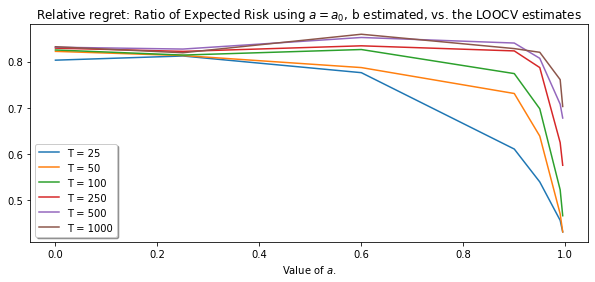

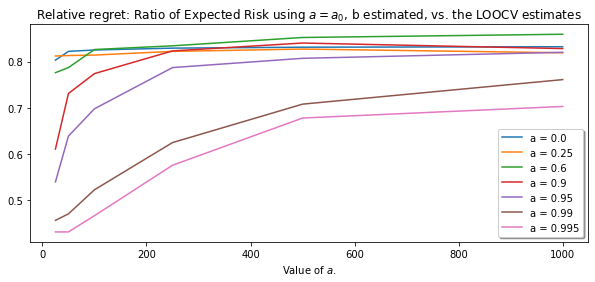

In [73]:
plt.figure(figsize = (10, 4))
plt.title(f"Relative regret: Ratio of Expected Risk using $a = a_0$, b estimated, vs. the LOOCV estimates")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(r_m.T):
    plt.plot(a_range, plot, label = f"T = {T_range[i]}")
    # plt.fill_between(a_range, plot - avg_regrets_sem[:, i], plot + avg_regrets_sem[:, i], alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.title(f"Relative regret: Ratio of Expected Risk using $a = a_0$, b estimated, vs. the LOOCV estimates")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(r_m):
    plt.plot(T_range, plot, label = f"a = {a_range[i]}")
    # plt.fill_between(T_range, plot - avg_regrets_sem[i], plot + avg_regrets_sem[i], alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.show()

In [18]:
def expected_cost_ar(a_true, a_est, b_true = 0, b_est = 0):
    
    # base on the distribution of X, no actual data needed.    
    covariance_X = 1 / (1 - a_true ** 2) + b_true ** 2
    
    # components
    noise = 1
    b_diff = (b_true - b_est) * ((b_true - b_est) + (a_true - a_est) * b_true - a_true * b_true + a_est * b_est)
    mean_X = (a_true - a_est) * b_true * ((b_true - b_est) - a_true * b_true + a_est * b_est)
    cov_x = (a_true - a_est) ** 2 * covariance_X
    ab = - 1 * a_true * b_true * ((b_true - b_est) + (a_true - a_est) * b_true - a_true * b_true + a_est * b_est)
    ab_est = a_est * b_est * ((b_true - b_est) + (a_true - a_est) * b_true - a_true * b_true + a_est * b_est)

    # return expected MSE
    return noise + b_diff + mean_X + ab + ab_est + cov_x

## generate AR(1) model
a = np.random.random()
a_est = np.random.random()
b = 1e3 * np.random.random()
b_est = 1e3 * np.random.random()
print(round(a, 2), round(a_est, 2), round(b, 2), round(b_est, 2))
T = 50000

X = np.zeros(T)
X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))

# generate noise
noises = np.random.normal(0, 1, T - 1)

# iteratively get value of X
for t in range(1, T):
    X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

print(f"a:\t{round(a, 3)}, b:\t{round(b, 3)}.")
b_est = ((sum(X) - X[0]) - a * (sum(X) - X[-1])) / ((T - 1) * (1 - a))
print(f"CV_0 score: {round(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - a * (X[:-1] - b_est), 2) ** 2, 3)}.")
print(f"CV_1 score: {round(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - a * (X[:-1] - b_est), 2) ** 2, 3)}.")
print(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - a_est * (X[:-1] - b_est), 2) ** 2)
print(expected_cost_ar(a, a_est, b, b_est))

0.36 0.38 9.57 36.14
a:	0.356, b:	9.572.
CV_0 score: 1.002.
CV_1 score: 1.002.
1.0029956612985558
1.00068497500686


In [19]:
a0, b, T, iters, iters2 = 0.99, 0, 5001, 100, 100
count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
print(count / iters)

a0, b, T, iters, iters2 = 0.999, 0, 5001, 100, 100
count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
print(count / iters)

a0, b, T, iters, iters2 = 0.9999, 0, 5001, 100, 100
count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
print(count / iters)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

b: -1.5943 	 -1.6275
a: 0.99 	 0.9872586997027327



  1%|▊                                                                                 | 1/100 [00:18<31:01, 18.81s/it]

average empirical risk:	 0.9705 	 0.9702
true risk:		 1.0003 	 1.0008
cross-validation score:	 0.9707 	 0.971

0
0.9994467861155485
b: -0.6193 	 -0.5871
a: 0.99 	 0.9840013326762757



  2%|█▋                                                                                | 2/100 [00:44<36:53, 22.59s/it]

average empirical risk:	 0.9919 	 0.9908
true risk:		 1.0 	 1.0019
cross-validation score:	 0.992 	 0.9913

1
0.99814518779124
b: 1.2409 	 1.2364
a: 0.99 	 0.99053096360846



  2%|█▋                                                                                | 2/100 [01:06<54:38, 33.45s/it]

average empirical risk:	 1.0411 	 1.0411


KeyboardInterrupt: 

In [67]:
# a0, b, T, iters, iters2 = 0.99, 0, 10001, 25, 100
# count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
# print(count / iters)

# a0, b, T, iters, iters2 = 0.999, 0, 10001, 25, 100
# count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
# print(count / iters)

a0, b, T, iters, iters2 = 0.9999, 0, 50001, 25, 100
count = ar_loocv_2(a0, b, T, iters, approx_b = True, one_pair = False, iter_estimate = True, iters2 = iters2)
print(count / iters)

  0%|                                                                                           | 0/25 [00:32<?, ?it/s]


IndexError: index 49999 is out of bounds for axis 0 with size 49999

In [ ]:
# a \ T | 5001    10001
# 0.9900| 0.75   0.80
# 0.9990| 0.70   0.88
# 0.9999| 0.42   0.56
#a = 0.999, T = 5001, 100 iters => 0.76
#a = 0.990, T = 5001, 10 iters => 1.00

In [ ]:
# remove X_k_pair.
# Use estimate for b without a
# Iteratively estimate a and b to find the true MLEs

def regret(a, b, T, iters = 100, approx_b = True, iter_estimate = False, one_pair = True, iters2 = 5):
    
    count = 0
    regrets = np.array([])
    
    for _ in tqdm(range(iters)):

        ## generate AR(1) model
        X = np.zeros(T)
        X[0] = np.random.normal(b, np.sqrt(1 / (1 - a ** 2)))
        
        # generate noise
        noises = np.random.normal(0, 1, T - 1)
        
        # iteratively get value of X
        for t in range(1, T):
            X[t] = b + a * (X[t - 1] - b) + noises[t - 1]

        # get sum
        sum_X = sum(X)

        # LOOCV parameter estimates, CV scores
        CV_0 = np.zeros(T - 1)
        CV_1 = np.zeros(T - 1)
        hat_a = np.zeros(T)
        hat_b = np.zeros(T)
        
        b_est = ((sum_X - X[0]) - a * (sum_X - X[-1])) / ((T - 1) * (1 - a))
        
        hat_b_one = np.zeros(T)
        
        if one_pair:
            hat_b_one[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
        else: 
            hat_b_one[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a))
            
        # estimate b, either exact or approximate
        if not approx_b:
            if one_pair:
                hat_b[:-1] = ((sum_X - X[0] - X[1:]) - a * (sum_X - X[-1] - X[:-1])) / ((T - 2) * (1 - a))
            else:
                hat_b[1:-1] = ((sum_X - X[0] - X[1:-1] - X[2:]) - a * (sum_X - X[-1] - X[1:-1] - X[:-2])) / ((T - 3) * (1 - a))
        else:
            hat_b[:-1] = (sum_X - X[:-1]) / (T - 1)
        
        # estimate a, either remove pair (X_k, X_k+1) or also (X_k-1, X_k)
        if one_pair:
            hat_a[1:-1] = get_a_hat_pair(X, hat_b)
        else:
            hat_a[1:-1] = get_a_hat_both_v2(X, hat_b)
        
        # compute LOOCV score for each sample excluding boundary
        for t in range(1, T - 1):      
            # iteratively estimate to get optimal MLE estimates
            if iter_estimate and one_pair:
                hat_a[t], hat_b[t] = loocv_one_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)                
            elif iter_estimate and not one_pair:
                hat_a[t], hat_b[t] = loocv_two_pair(hat_a[t], hat_b[t], X, t, sum_X, T, iters = iters2)

            # compare a_est and b_est
            CV_0[t] = (X[t + 1] - hat_b_one[t]    - a        * (X[t] - hat_b_one[t]))    ** 2
            CV_1[t] = (X[t + 1] - hat_b[t] - hat_a[t] * (X[t] - hat_b[t])) ** 2
            
            # compare a_est and b_est
#             CV_0[t] = (X[t + 1] - a        * X[t])    ** 2
#             CV_1[t] = (X[t + 1] - hat_a[t] * X[t]) ** 2

#         # get count   
#         print("b:", round(np.mean(b_est), 4), "\t", round(np.mean(hat_b[1:-1]), 4))
#         print("a:", np.mean(a), "\t", np.mean(hat_a[1:-1]))
#         print()
#         print("average empirical risk:\t", round(1 / (T - 1) * np.mean(np.array([np.linalg.norm((X[2:] - b) - a * (X[1:-1] - b), 2) ** 2 for b in hat_b_one[1:-1]])), 4), "\t", round(1 / (T - 1) * np.mean(np.array([np.linalg.norm((X[2:] - b) - a * (X[1:-1] - b), 2) ** 2 for a, b in zip(hat_a[1:-1], hat_b[1:-1])])), 4))
#         print("true risk:\t\t", np.round(np.array(expected_cost_ar(a, a, b, b_est)), 4), "\t", round(np.mean(np.array([expected_cost_ar(a, a_hat, b, b_hat) for a_hat, b_hat in zip(hat_a[1:-1], hat_b[1:-1])])), 4))
#         print("cross-validation score:\t", round(1 / (T - 1) * sum(CV_0), 4), "\t", round(1 / (T - 1) * sum(CV_1), 4))
#         print()
#         print(count)
        
        regret_v = np.mean(np.array([expected_cost_ar(a, a_hat, b, b_hat) for a_hat, b_hat in zip(hat_a[1:-1], hat_b[1:-1])])) / np.mean([expected_cost_ar(a, a, b, b_) for b_ in hat_b_one[1:-1]])
        
        regrets = np.append(regrets, 1 / regret_v)
        count += (sum(CV_0) < sum(CV_1))
        
    
    return count # np.mean(regrets), sem(regrets)

a0, b, T, iters, iters2 = 0.9999, 0, 251, 500, 100

avg_regrets = np.zeros((len(a_range), len(T_range)))
avg_regrets_sem = np.zeros((len(a_range), len(T_range)))

regret(a0, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2)

# a_range = [0.0, 0.3, 0.6, 0.9, 0.99, 0.999]
# T_range = [25, 50, 100, 150, 250, 501]
# for i, a0 in enumerate(a_range):
#     for j, T in enumerate(T_range):
#         print(a0, T)
#         print(regret(a0, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2))
#         mean, se = regret(a0, b, T, iters, approx_b = True, one_pair = True, iter_estimate = True, iters2 = iters2)
#         avg_regrets[i][j] = mean
#         avg_regrets_sem[i][j] = se
# print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

# count = martin_remove_x_k_both(a0, b, T, iters)
# print(f"P(CV(a = a0 = {a0}) < CV(a = hat(a)) = {round(count / iters, 3)}.")

In [106]:
print(avg_regrets)
print(avg_regrets_sem)

[[ 1.0480642   1.02091442  1.00909894  1.00655672  1.00350364  1.00212826]
 [ 1.04456183  1.01995044  1.00986059  1.00812533  1.00426459  1.0019606 ]
 [ 1.10638306  1.04098145  1.01568941  1.00797115  1.00403032  1.00209884]
 [ 1.3648935   1.12467009  1.04283281  1.01968675  1.00672374  1.00332585]
 [ 8.14916141  2.41329295  1.31661255  1.15386279  1.0401742   1.01415146]
 [64.60194287 26.71515464  5.08912391  2.53759801  1.66246127  1.21133113]]
[[6.05165077e-03 2.33176999e-03 1.28872081e-03 8.90667920e-04
  5.15079604e-04 3.05707397e-04]
 [7.44945150e-03 3.44995811e-03 1.51534387e-03 1.20620705e-03
  5.53255913e-04 3.34951344e-04]
 [1.53300544e-02 7.04153209e-03 3.72524732e-03 1.71292499e-03
  8.34972057e-04 2.87217264e-04]
 [6.36705270e-02 1.88556224e-02 9.73379121e-03 3.12286550e-03
  9.97561317e-04 5.48009258e-04]
 [1.38880285e+00 2.56252308e-01 5.22266473e-02 3.50725557e-02
  6.40099424e-03 2.00341633e-03]
 [1.14465131e+01 9.51095375e+00 8.97160272e-01 2.46872674e-01
  1.12098243

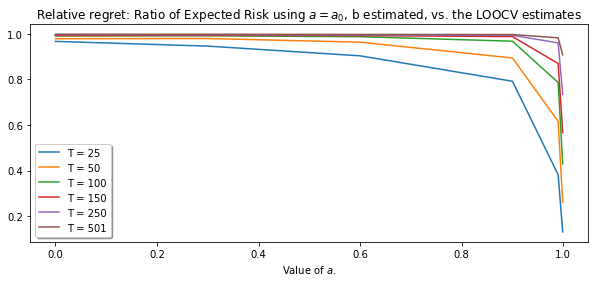

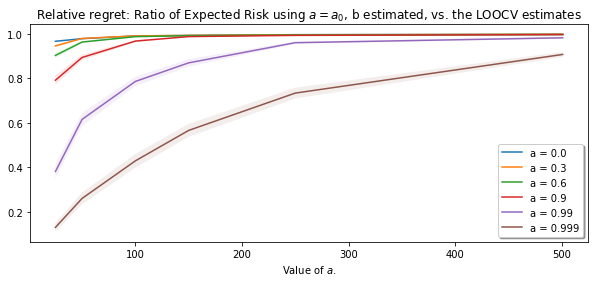

In [114]:
plt.figure(figsize = (10, 4))
plt.title(f"Relative regret: Ratio of Expected Risk using $a = a_0$, b estimated, vs. the LOOCV estimates")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(avg_regrets.T):
    plt.plot(a_range, plot, label = f"T = {T_range[i]}")
    # plt.fill_between(a_range, plot - avg_regrets_sem[:, i], plot + avg_regrets_sem[:, i], alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.show()

plt.figure(figsize = (10, 4))
plt.title(f"Relative regret: Ratio of Expected Risk using $a = a_0$, b estimated, vs. the LOOCV estimates")
plt.xlabel(r"Value of $a$.")

for i, plot in enumerate(avg_regrets):
    plt.plot(T_range, plot, label = f"a = {a_range[i]}")
    plt.fill_between(T_range, plot - avg_regrets_sem[i], plot + avg_regrets_sem[i], alpha = 0.1)
    
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.show()